<a href="https://colab.research.google.com/github/pranamyasin/projects/blob/main/time_series_tractor_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from io import StringIO
import requests
import calendar
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv(r'http://www.ucanalytics.com/blogs/wp-content/uploads/2015/06/Tractor-Sales.csv')
data

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203
...,...,...
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519


In [3]:
data.info()       #No null values are prsent  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Month-Year              144 non-null    object
 1   Number of Tractor Sold  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


# PREPROCESSING

In [4]:
dates = pd.date_range(start = "2003-01-01", freq="MS", periods= len(data))
dates

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

In [5]:
data["Months"] = dates.month
data["Months"] = data["Months"].apply(lambda x: calendar.month_abbr[x])   #Because of this line we will get(Jan, Feb) instead of (1st, 2nd) month

data["Year"] = dates.year
data.rename(columns = {"Number of Tractor Sold":"Tractor-Sales"}, inplace= True)  
data.drop(["Month-Year"], axis=1, inplace= True)        #since months and years have already been seperated 

In [6]:
data.head()

,Tractor-Sales,Months,Year
0,141,Jan,2003
1,157,Feb,2003
2,185,Mar,2003
3,199,Apr,2003
4,203,May,2003


In [7]:
data.set_index(dates, inplace=True)
data.head()

,Tractor-Sales,Months,Year
2003-01-01,141,Jan,2003
2003-02-01,157,Feb,2003
2003-03-01,185,Mar,2003
2003-04-01,199,Apr,2003
2003-05-01,203,May,2003


In [8]:
data.columns

Index(['Tractor-Sales', 'Months', 'Year'], dtype='object')

Text(0, 0.5, 'Tractor Sales')

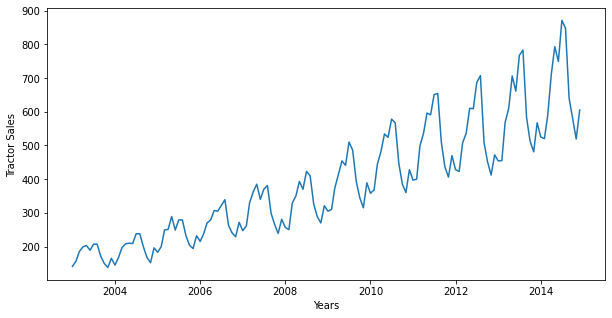

In [9]:
#BY PLOTTING
data_ts= data["Tractor-Sales"]
plt.figure(figsize=(10,5))
plt.plot(data_ts)
plt.xlabel("Years")
plt.ylabel("Tractor Sales")

In [10]:
#Through graph we can see that the tractor salaes in non stationary

In [11]:
X = data["Tractor-Sales"].values            #For futher confirmation 
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary") 

ADF Statistic: 1.108825
p-value: 0.995291
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Failed to Reject Ho - Time Series is Non-Stationary


# Decomposition


In [12]:
roll_mean = data_ts.rolling(window=12).mean()
roll_std = data_ts.rolling(window=12).std()


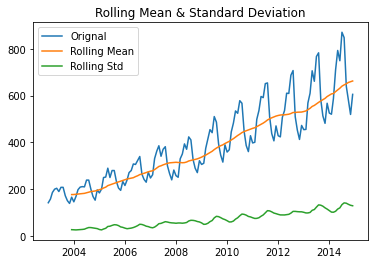

In [13]:
#Plotting Rolling Stats
orig = plt.plot(data_ts, label="Orignal")
mean = plt.plot(roll_mean, label="Rolling Mean")
std = plt.plot(roll_std, label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling Mean & Standard Deviation")
plt.show()

###Pivot Table for monthly sales

In [14]:
monthly_sales = pd.pivot_table(data, values= "Tractor-Sales",columns="Year",index="Months")
monthly_sales

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Months,,,,,,,,,,,,
Apr,199,208,251,279,362,350,414,482,536,536,610,710
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Dec,165,196,232,272,281,321,389,428,470,472,567,605
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Mar,185,197,249,270,330,329,374,444,498,507,568,587
May,203,210,289,307,385,393,454,534,596,610,706,793


In [15]:
#Re-Index 
monthly_sales= monthly_sales.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Months,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


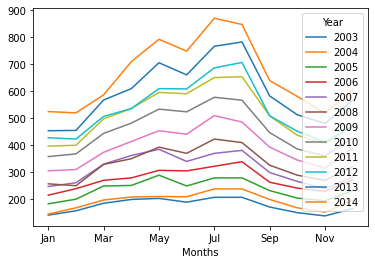

In [16]:
monthly_sales.plot()

### Yearly Data plot using box plot

In [17]:
yearly_sales= pd.pivot_table(data, values = "Tractor-Sales", columns = "Months", index = "Year")
yearly_sales

Months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Year,,,,,,,,,,,,
2003,199,207,165,157,141,207,189,185,203,138,150,171
2004,208,238,196,168,145,238,209,197,210,152,168,199
2005,251,279,232,200,183,279,249,249,289,194,204,232
2006,279,339,272,239,215,322,305,270,307,229,241,263
2007,362,381,281,261,247,370,340,330,385,239,266,299
2008,350,410,321,250,257,423,370,329,393,270,289,326
2009,414,486,389,310,305,510,441,374,454,315,345,393
2010,482,567,428,368,358,578,524,444,534,360,386,447
2011,536,654,470,400,397,651,591,498,596,406,437,509


In [18]:
#Re-Index months
yearly_sales= yearly_sales.reindex(columns = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
yearly_sales

Months,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141,157,185,199,203,189,207,207,171,150,138,165
2004,145,168,197,208,210,209,238,238,199,168,152,196
2005,183,200,249,251,289,249,279,279,232,204,194,232
2006,215,239,270,279,307,305,322,339,263,241,229,272
2007,247,261,330,362,385,340,370,381,299,266,239,281
2008,257,250,329,350,393,370,423,410,326,289,270,321
2009,305,310,374,414,454,441,510,486,393,345,315,389
2010,358,368,444,482,534,524,578,567,447,386,360,428
2011,397,400,498,536,596,591,651,654,509,437,406,470


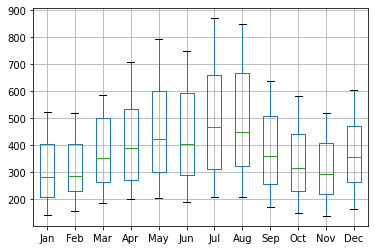

In [19]:
yearly_sales.boxplot()

###Decomposing Time series

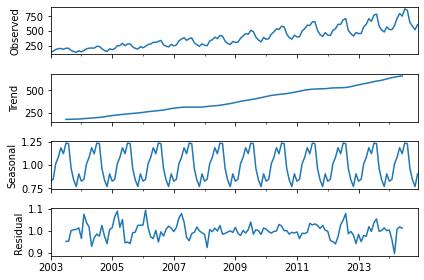

In [20]:
decomp = sm.tsa.seasonal_decompose(data_ts, model="multiplicative")
fig = decomp.plot()

In [21]:
#PDQ Parameter determination


In [22]:
d = q = range(0,2)  #d = No of Non-Seasonal difference needed for stationarity/// q= No of lag/forecast error in the prediction
p = range(0,4)  #Its the No of Autoregressive Term

In [23]:
pdq= list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1),
 (2, 0, 0),
 (2, 0, 1),
 (2, 1, 0),
 (2, 1, 1),
 (3, 0, 0),
 (3, 0, 1),
 (3, 1, 0),
 (3, 1, 1)]

In [24]:
seasonal_pdq = [(x[0],x[1],x[2],12) for x in pdq]           #inorder to add the seasonality if present(since sesonality is sean in 12 months, 12 is added)
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (3, 0, 0, 12),
 (3, 0, 1, 12),
 (3, 1, 0, 12),
 (3, 1, 1, 12)]

In [25]:
print("ARIMAX: {} X {}".format(pdq[1],seasonal_pdq[1]))

ARIMAX: (0, 0, 1) X (0, 0, 1, 12)


# SRIMAX MODEL at minimum aic present

In [26]:
warnings.filterwarnings("ignore")
AIC = [] #Alkaline Information Curve==> It define accuracy of DATA and how to predict the future data
         # AIC is used to give best accuracy by using minimum features
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_ts,
                                           order=param,
                                           seasonal_order=param_seasonal) 
            results = mod.fit()
            
            print("SARIMAX{}x{} = AIC:{}".format(param, param_seasonal, results.aic), end="\r" )
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [27]:
#SMALLEST AIC
print("The smallest AIC {} for model SARIMAX {} x {}".format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC 1111.4861343333932 for model SARIMAX (2, 1, 1) x (2, 1, 1, 12)


In [28]:
SARIMAX_model[AIC.index(min(AIC))][0]

(2, 1, 1)

In [29]:
min(AIC)

1111.4861343333932

In [30]:
AIC.index(min(AIC))

178

In [32]:
SARIMAX_model[178]

[(2, 1, 1), (2, 1, 1, 12)]

In [33]:
SARIMAX_model[239][0]

(3, 1, 1)

In [34]:
SARIMAX_model[239][1]

(3, 0, 0, 12)

In [36]:
mod = sm.tsa.statespace.SARIMAX(data_ts,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [37]:
#FITTING THE MODEL
results = mod.fit()

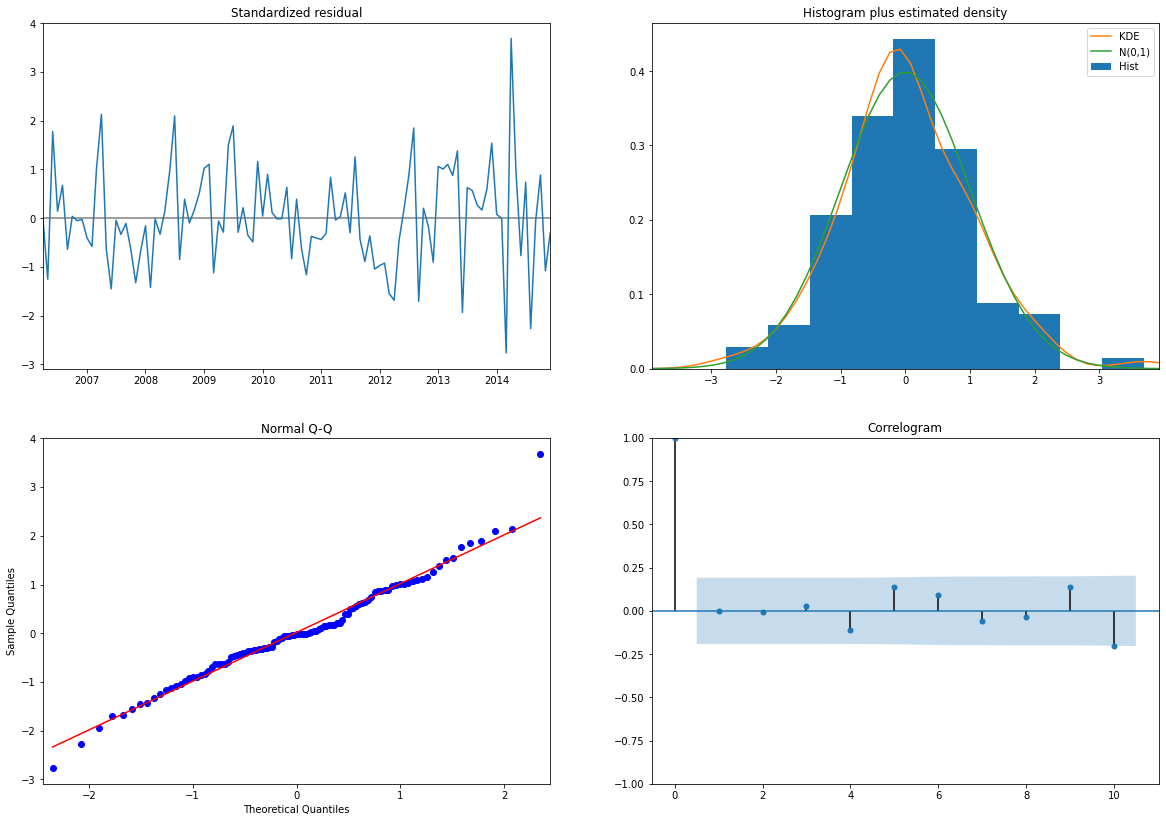

In [38]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

# Predictions


In [39]:
#1-step ahead forecasting implies that each forecasted point is used to predict the following one.
pred0 = results.get_prediction(start='2003-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [40]:

pred1 = results.get_prediction(start='2003-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [41]:
pred2 = results.get_forecast('2016-01-01')
# Give the end year till we want forecast which 2016 jan
pred2_ci = pred2.conf_int()

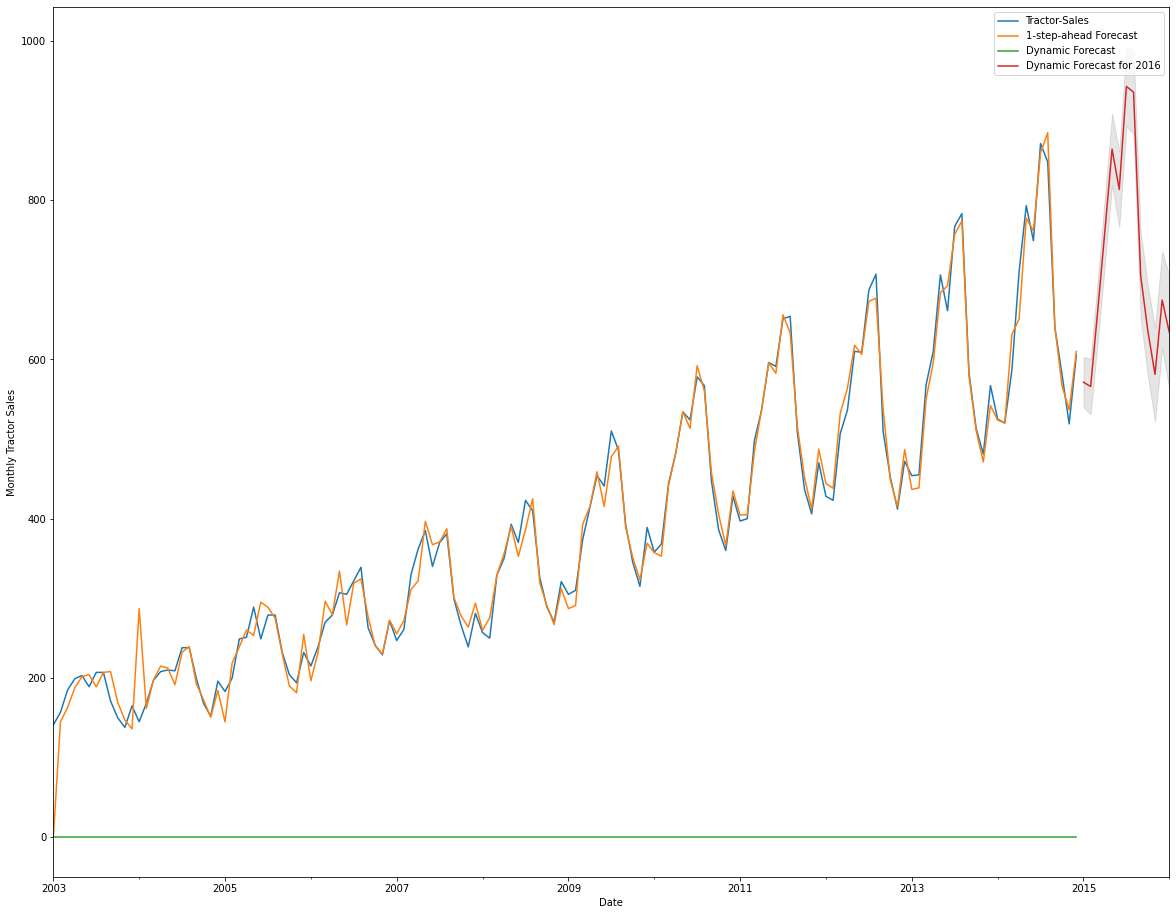

In [43]:
#Plot the predicted values
ax = data_ts.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast for 2016')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly Tractor Sales')
plt.xlabel('Date')
plt.legend()
plt.show()

In [44]:
pred1

In [45]:
pred2_ci.head()

,lower Tractor-Sales,upper Tractor-Sales
2015-01-01,539.700949,602.862545
2015-02-01,530.850207,600.975289
2015-03-01,622.677687,700.869935
2015-04-01,719.840679,804.095659
2015-05-01,818.934000,908.905980


In [46]:
pred2_ci.iloc[:, 0].head()

2015-01-01    539.700949
2015-02-01    530.850207
2015-03-01    622.677687
2015-04-01    719.840679
2015-05-01    818.934000
Freq: MS, Name: lower Tractor-Sales, dtype: float64

In [47]:
pred2_ci.iloc[:, 1].head()

2015-01-01    602.862545
2015-02-01    600.975289
2015-03-01    700.869935
2015-04-01    804.095659
2015-05-01    908.905980
Freq: MS, Name: upper Tractor-Sales, dtype: float64

In [48]:
pred2_ci.index

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01'],
              dtype='datetime64[ns]', freq='MS')